In [3]:
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, class_size, dropout=0.5, rnn_type='lstm'):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.class_size = class_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,     # rnn hidden unit
                num_layers=self.num_layers,       # number of rnn layer
                batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            )
        elif self.rnn_type == 'rnn':
            self.rnn = nn.RNN(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
            )
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
            )
        else:
            raise NotImplementedError

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(self.hidden_size, self.class_size) # FC layer in our paper

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        if self.rnn_type == 'lstm':
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
            r_out, _ = self.rnn(x, (h0, c0))
        else:
            r_out, _ = self.rnn(x, h0)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(self.dropout((r_out[:, time_step, :]))))
        return torch.stack(outs, dim=1)

In [5]:
ss_X_dep = StandardScaler()
ss_y_dep = StandardScaler()

def rmse(y1, y2):
    return np.sqrt(mean_squared_error(y1, y2))

In [6]:
data = pd.read_csv('data/demo.csv')

Inputs = data.drop('Year', axis=1).drop('Depth', axis=1)
Outputs = data['Depth']

In [7]:
Inputs = Inputs.as_matrix()
Outputs = Outputs.as_matrix().reshape(-1, 1)

/home/akshay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/akshay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
# First 12 years of data
X_train_dep = Inputs[0:144]
y_train_dep = Outputs[0:144]

# Last 2 years of data
X_test_dep = Inputs[144:]

print("X_train_dep shape", X_train_dep.shape)
print("y_train_dep shape", y_train_dep.shape)
print("X_test_dep shape", X_test_dep.shape)

X_train_dep shape (144, 5)
y_train_dep shape (144, 1)
X_test_dep shape (24, 5)


In [10]:
X = np.concatenate([X_train_dep, X_test_dep], axis=0)

# Standardization
X = ss_X_dep.fit_transform(X)

# First 12 years of data
X_train_dep_std = X[0:144]
y_train_dep_std = ss_y_dep.fit_transform(y_train_dep)

In [11]:
# All 14 years of data
X_test_dep_std  = X
X_train_dep_std = np.expand_dims(X_train_dep_std, axis=0)
y_train_dep_std = np.expand_dims(y_train_dep_std, axis=0)
X_test_dep_std = np.expand_dims(X_test_dep_std, axis=0)

In [12]:
# Transfer to Pytorch Variable
X_train_dep_std = Variable(torch.from_numpy(X_train_dep_std).float())
y_train_dep_std = Variable(torch.from_numpy(y_train_dep_std).float())
X_test_dep_std = Variable(torch.from_numpy(X_test_dep_std).float())

In [13]:
# Define rnn model
model = RNN(input_size=5, hidden_size=40, num_layers=1, class_size=1, dropout=0.5, rnn_type='lstm')
# Define optimization function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)   # optimize all rnn parameters
# Define loss function
loss_func = nn.MSELoss()

In [14]:
# Start training
for iter in range(20000+1):
    model.train()
    prediction = model(X_train_dep_std)
    loss = loss_func(prediction, y_train_dep_std)
    optimizer.zero_grad()  # clear gradients for this training step
    loss.backward()        # back propagation, compute gradients
    optimizer.step()
    if iter % 100 == 0:
        print("iteration: %s, loss: %s" % (iter, loss.item()))

iteration: 0, loss: 0.9967653751373291
iteration: 100, loss: 0.9369235634803772
iteration: 200, loss: 0.837751030921936
iteration: 300, loss: 0.7274081707000732
iteration: 400, loss: 0.6605933308601379
iteration: 500, loss: 0.5598281621932983
iteration: 600, loss: 0.5551613569259644
iteration: 700, loss: 0.5056695342063904
iteration: 800, loss: 0.46955549716949463
iteration: 900, loss: 0.43161651492118835
iteration: 1000, loss: 0.3978692889213562
iteration: 1100, loss: 0.3831895589828491
iteration: 1200, loss: 0.3572118282318115
iteration: 1300, loss: 0.3429827392101288
iteration: 1400, loss: 0.3552069664001465
iteration: 1500, loss: 0.30689603090286255
iteration: 1600, loss: 0.3141506016254425
iteration: 1700, loss: 0.3197340667247772
iteration: 1800, loss: 0.29536595940589905
iteration: 1900, loss: 0.26679959893226624
iteration: 2000, loss: 0.23972143232822418
iteration: 2100, loss: 0.23563718795776367
iteration: 2200, loss: 0.24989578127861023
iteration: 2300, loss: 0.23858854174613

iteration: 19000, loss: 0.05233219265937805
iteration: 19100, loss: 0.05413079261779785
iteration: 19200, loss: 0.05548214167356491
iteration: 19300, loss: 0.04707759991288185
iteration: 19400, loss: 0.04706839472055435
iteration: 19500, loss: 0.0480974055826664
iteration: 19600, loss: 0.06374835222959518
iteration: 19700, loss: 0.04778037220239639
iteration: 19800, loss: 0.04075871780514717
iteration: 19900, loss: 0.04632258415222168
iteration: 20000, loss: 0.045240189880132675


In [16]:
# Save model
save_filename = 'checkpoints/LSTM_FC.pth'
torch.save(model, save_filename)
print('Saved as %s' % save_filename)

Saved as checkpoints/LSTM_FC.pth


/home/akshay/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
# Start evaluating model
model.eval()

RNN(
  (rnn): LSTM(5, 40, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=40, out_features=1, bias=True)
)

In [18]:
y_pred_dep_ = model(X_test_dep_std).detach().numpy()
y_pred_dep = ss_y_dep.inverse_transform(y_pred_dep_[0, 144:])

print('the value of R-squared of Evaporation is ', r2_score(Outputs[144:], y_pred_dep))
print('the value of Root mean squared error of Evaporation is ', rmse(Outputs[144:], y_pred_dep))

the value of R-squared of Evaporation is  0.58388605520776
the value of Root mean squared error of Evaporation is  1.0610613888141551


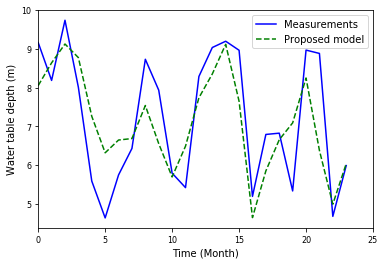

In [19]:
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))

ax1.plot(Outputs[144:], color="blue", linestyle="-", linewidth=1.5, label="Measurements")
ax1.plot(y_pred_dep, color="green", linestyle="--", linewidth=1.5, label="Proposed model")

plt.legend(loc='upper right')
plt.xticks(fontsize=8,fontweight='normal')
plt.yticks(fontsize=8,fontweight='normal')
plt.xlabel('Time (Month)', fontsize=10)
plt.ylabel('Water table depth (m)', fontsize=10)
plt.xlim(0, 25)
plt.savefig('results.png', format='png')
plt.show()

In [20]:
##### Loading Model #####
model = torch.load('checkpoints/LSTM_FC.pth')
model.eval()
y_pred_dep_ = model(X_test_dep_std).detach().numpy()
y_pred_dep = ss_y_dep.inverse_transform(y_pred_dep_[0, 144:])

print('the value of R-squared of Evaporation is ', r2_score(Outputs[144:], y_pred_dep))
print('the value of Root mean squared error of Evaporation is ', rmse(Outputs[144:], y_pred_dep))

the value of R-squared of Evaporation is  0.58388605520776
the value of Root mean squared error of Evaporation is  1.0610613888141551
